In [1]:
import torch
import numpy as np
from diff_trainer import extract
from matplotlib import pyplot as plt
import diffusers
import os
from fucs import save_image
import fucs
from coders import cal_acc
from diffusers import UNet2DConditionModel

f:\Anaconda\envs\nc\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import Unetwork
import diff_trainer
import config
%load_ext autoreload
%autoreload 1
%aimport config
%aimport fucs
modelconfig = config.vscodeconfig

current platform:  nt


In [ ]:
import torch

def generate_similar_tensor(input_tensor: torch.Tensor, target_mse: float) -> torch.Tensor:
    """
    生成一个与输入张量形状相同的新张量，使得两者之间的MSE等于目标值。
    
    Args:
        input_tensor (torch.Tensor): 输入张量。
        target_mse (float): 目标MSE值（必须非负）。
        
    Returns:
        torch.Tensor: 生成的张量。
    """
    if target_mse < 0:
        raise ValueError("目标MSE必须为非负数。")
    if target_mse == 0:
        return input_tensor.clone()
    
    # 生成标准正态分布的噪声
    noise = torch.randn_like(input_tensor)
    
    # 计算当前噪声的MSE
    current_mse = torch.mean(noise ** 2)
    
    # 处理极小概率的current_mse=0情况（如随机数全为0）
    while current_mse == 0:
        noise = torch.randn_like(input_tensor)
        current_mse = torch.mean(noise ** 2)
    
    # 计算缩放因子
    scale = torch.sqrt(torch.tensor(target_mse / current_mse))
    
    # 调整噪声幅度
    scaled_noise = noise * scale
    
    # 合成输出张量
    output = input_tensor + scaled_noise
    
    return output

In [3]:
print(modelconfig['eval_load_weight'])
with torch.no_grad():
    device = torch.device(modelconfig['device'])
    model = UNet2DConditionModel(
        sample_size=32,
        in_channels=1,            # Stable Diffusion 的 latent 空间通道数
        out_channels=1,
        block_out_channels=(128, 256, 512, 512),
        cross_attention_dim=10,  # 条件嵌入的维度（如文本编码的 hidden_size）
        attention_head_dim=8,     # 注意力头数
    )
    ckpt = torch.load(
        os.path.join(modelconfig['save_weight_dir'], modelconfig['eval_load_weight']),
        map_location=device
    )
    model.load_state_dict(ckpt)
    model.eval()


ckpt97_.pt


In [ ]:
for file_name in os.listdir(modelconfig["hr_path"]):
    data = np.load(os.path.join(modelconfig["hr_path"], file_name))
    if np.isnan(data).any():
        print(file_name, "has nan")
        continue
    else:
        x0 = torch.from_numpy(data)
        condition = torch.from_numpy(np.load(os.path.join(modelconfig["lr_path"], file_name)))
        print(file_name, "has no nan")
        break

torch.Size([1, 1, 32, 32]) torch.Size([1, 10, 32, 32])


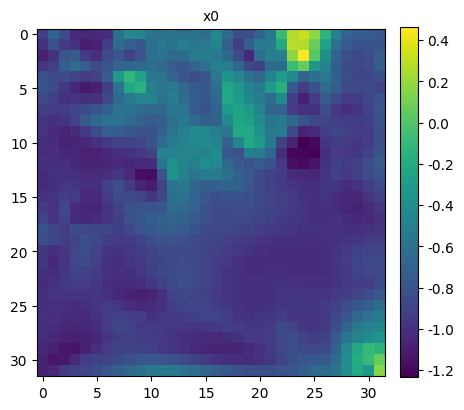

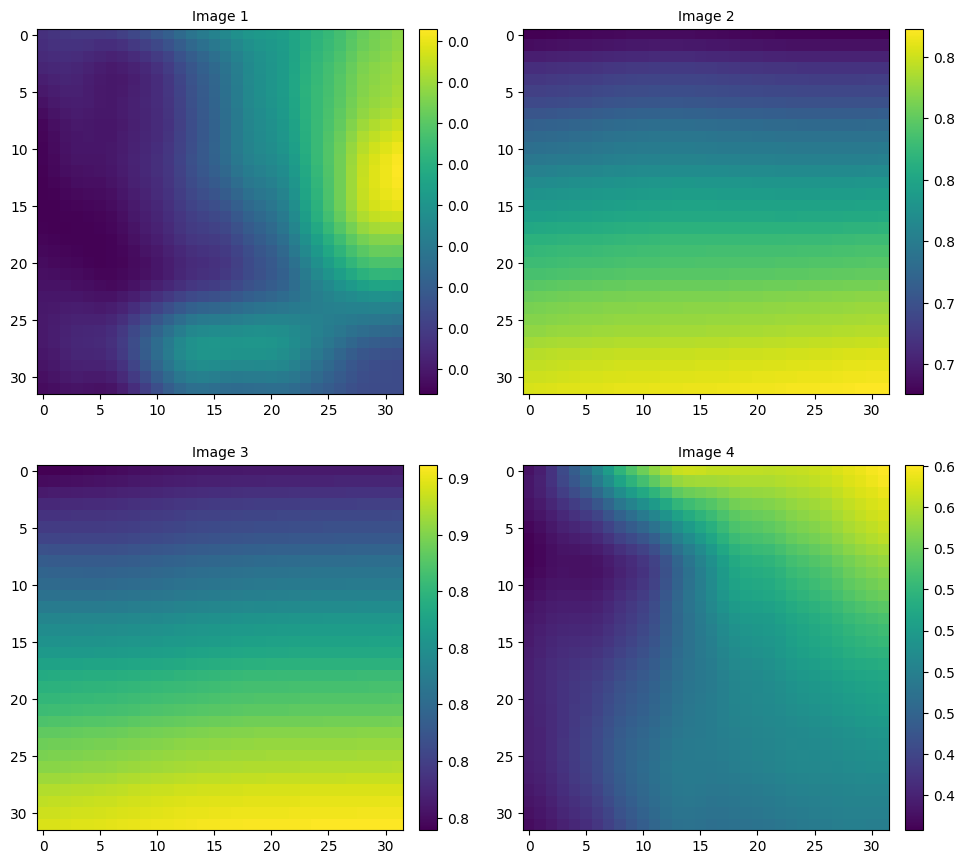

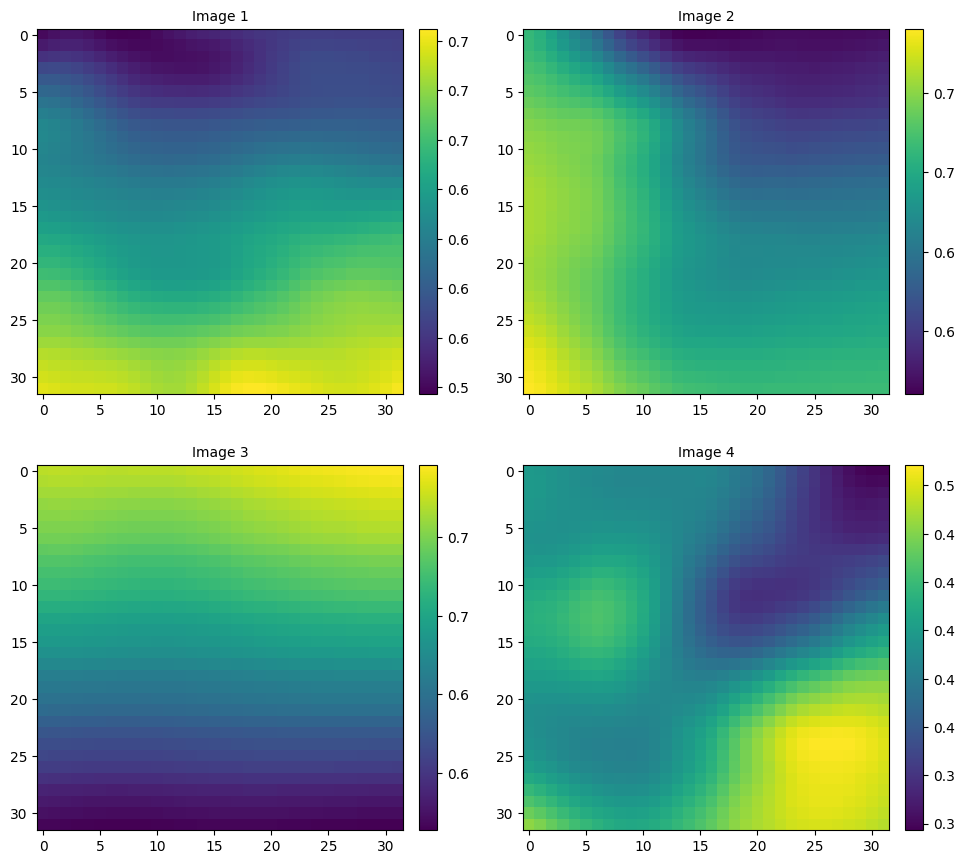

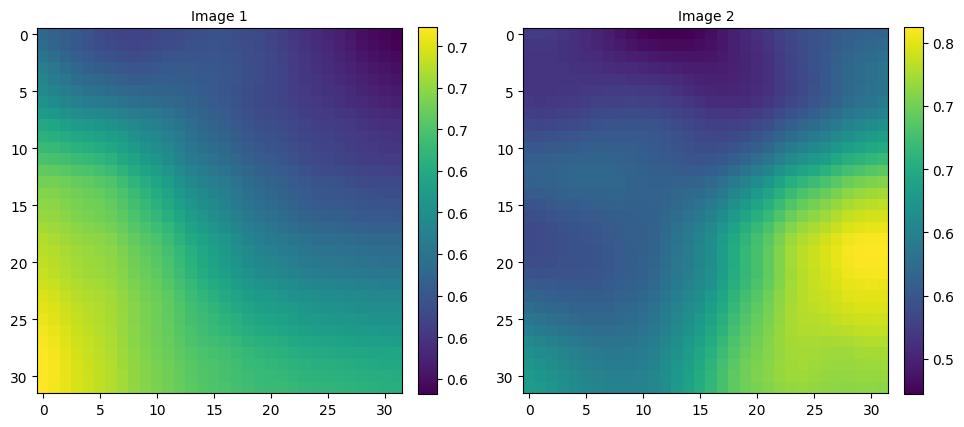

In [4]:
show_which = 0
x0 = torch.from_numpy(np.load(os.path.join(modelconfig["hr_path"], '10_10.npy'))).unsqueeze(1)[show_which:show_which+1]
condition0 = torch.from_numpy(np.load(os.path.join(modelconfig["lr_path"], '10_10.npy')))[show_which:show_which+1]
# condition2 = torch.from_numpy(np.load(os.path.join(modelconfig["lr_path"], '10_10.npy')))[show_which+1:show_which+2]
# condition3 = torch.from_numpy(np.load(os.path.join(modelconfig["lr_path"], '10_10.npy')))[show_which+50:show_which+51]
print(x0.shape, condition0.shape)
save_image(x0, names=['x0'], show=True)
nth_image = condition0[0]
save_image(nth_image[0], nth_image[1], nth_image[2], nth_image[3], show=True)
save_image(nth_image[4], nth_image[5], nth_image[6], nth_image[7], show=True)
save_image(nth_image[8], nth_image[9], show=True)

In [6]:
target_data_list = []
target_file_dir = modelconfig["hr_path"]
target_file_list = os.listdir(target_file_dir)
for file in target_file_list:
    file_path = os.path.join(target_file_dir, file)
    data = np.load(file_path, allow_pickle=True)#276,64,64
    target_data_list.append(data)

target_data = torch.from_numpy(np.stack(target_data_list).astype(np.float32))#189,274,32,32
target_data = torch.unsqueeze(target_data, dim=2)
target_data = target_data.view(-1, 1, 32, 32)#51786,1,32,32

model_file_dir = modelconfig["lr_path"]
model_file_list = os.listdir(model_file_dir)
assert model_file_list == target_file_list, '顺序完全一致！'
if model_file_list == target_file_list:
    print("顺序完全一致！")
model_data_list = []
for file in model_file_list:
    file_path = os.path.join(model_file_dir, file)
    data = np.load(file_path, allow_pickle=True)#274,10,32,32
    model_data_list.append(data)
condition = torch.from_numpy(np.stack(model_data_list).astype(np.float32))#189,274,10,32,32
condition = condition.view(-1, 10, 32, 32)#51786,10,32,32

顺序完全一致！


In [7]:
show_which = 3212
x0 = target_data[show_which:show_which+1]
condition0 = condition[show_which:show_which+1]
print(x0.shape, condition0.shape)

torch.Size([1, 1, 32, 32]) torch.Size([1, 10, 32, 32])


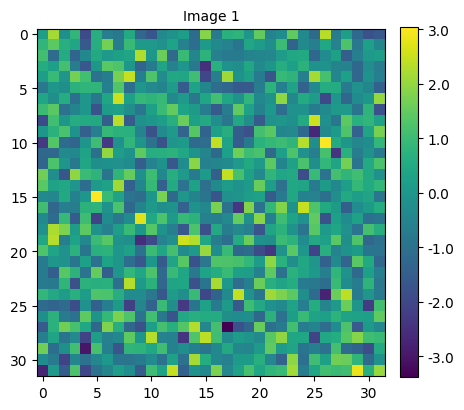

In [30]:
torch.manual_seed(42)
noise_to_add = torch.randn((1,1,32,32), device='cuda').float().repeat(50,1,1,1)
save_image(noise_to_add[2], show=True)

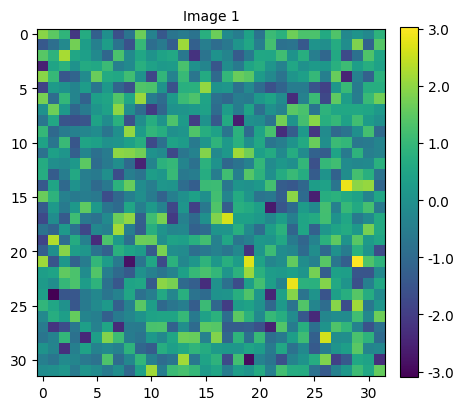

In [26]:
torch.manual_seed(42)
noise_to_add = torch.randn(1,1,32,32)
save_image(noise_to_add, show=True)

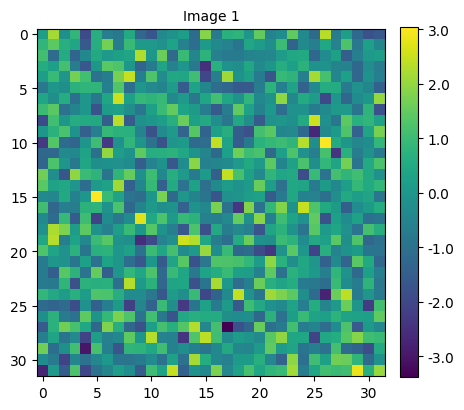

tensor(0.0002, grad_fn=<MeanBackward0>)
tensor([1.0000], grad_fn=<DivBackward0>)


In [26]:
ddim_sch = diffusers.schedulers.scheduling_ddim.DDIMScheduler(num_train_timesteps=200, beta_schedule='squaredcos_cap_v2', clip_sample=False)
t = 19
x0 = torch.nan_to_num(x0, nan=0.0)
torch.manual_seed(42)
noise_to_add = torch.randn((1,1,32,32), device='cuda').float().to('cpu')
save_image(noise_to_add, show=True)
# noise2 = torch.randn_like(x0).float()
xt = ddim_sch.add_noise(x0.float(), noise_to_add, torch.tensor([t]))
# condition = torch.zeros_like(condition)
encoder_hidden_states = condition0.flatten(2).permute(0, 2, 1)
# encoder_hidden_states2 = condition2.flatten(2).permute(0, 2, 1)
# encoder_hidden_states3 = condition3.flatten(2).permute(0, 2, 1)

eps = model(noise_to_add, t, encoder_hidden_states).sample
# eps2 = model(xt, t, encoder_hidden_states2).sample
loss = torch.nn.functional.mse_loss(noise_to_add, eps, reduction='none').mean()
# loss2 = torch.nn.functional.mse_loss(noise_to_add, eps2, reduction='none').mean()
acc = cal_acc(noise_to_add[0], eps[0])
# acc2 = cal_acc(noise_to_add[0], eps2[0])
print(loss)
print(acc)

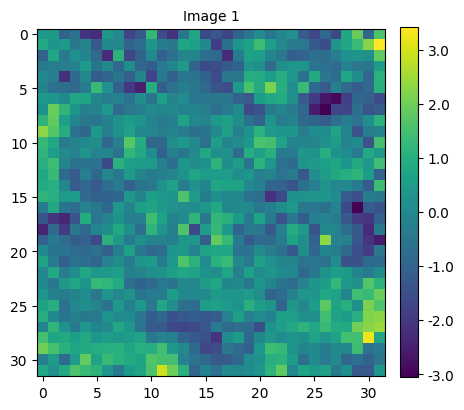

tensor(-0.0006, grad_fn=<MeanBackward0>)


In [36]:
eps2d = eps[0][0]
noise_to_add2d = noise_to_add[0][0]
deva = eps2d - noise_to_add2d
save_image(deva*100, show=True)
print(deva.mean())

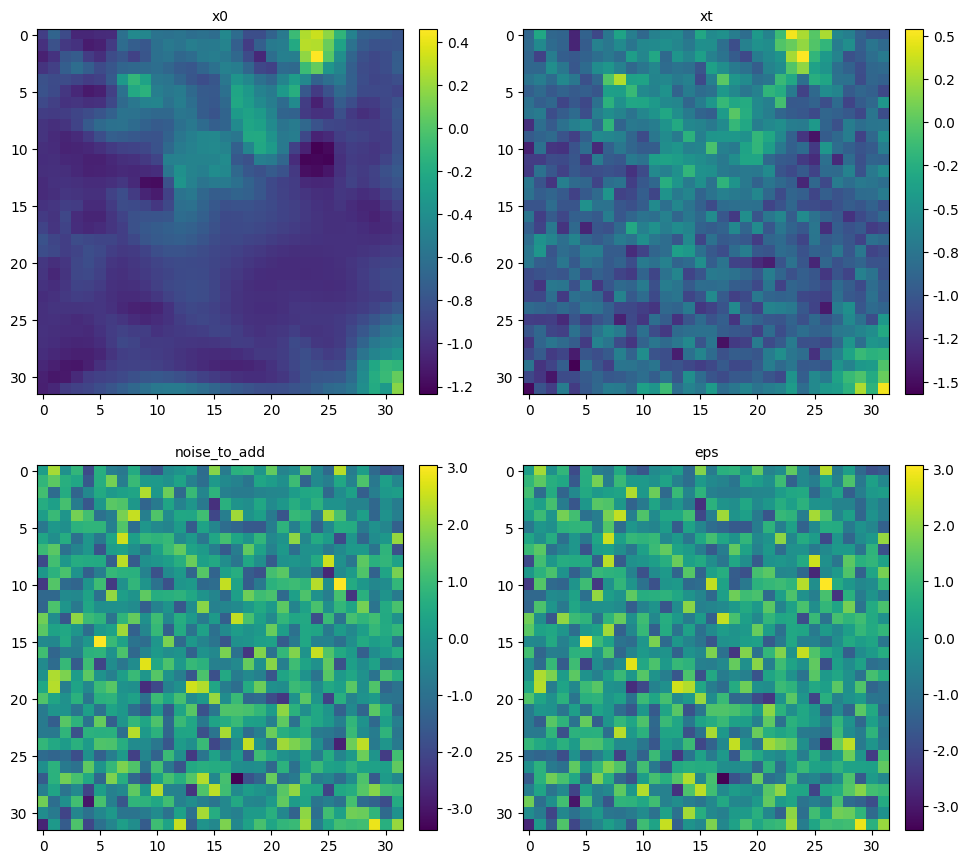

In [27]:
show_which = 0
save_image(x0[show_which], xt[show_which], noise_to_add[show_which], eps[show_which], names=['x0', 'xt', 'noise_to_add', 'eps'], show=True)

In [6]:
ddim_sch.set_timesteps(15)#设置时间步长
# slm_noise = generate_similar_tensor(noise_to_add, 0.000001)
# mse = torch.nn.functional.mse_loss(noise_to_add, slm_noise).mean()
# print(mse)
xt_1 = ddim_sch.step(eps, torch.tensor([199]), xt, eta=0,)
save_image(xt_1[0], xt_1[1], names=['xt_1', 'xt2'], show=True)

NameError: name 'ddim_sch' is not defined

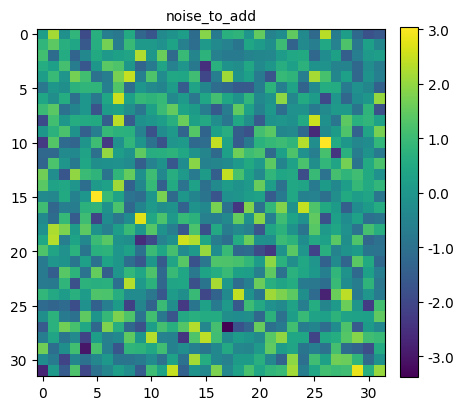

张量形状: (1, 1024, 10)
没有NaN


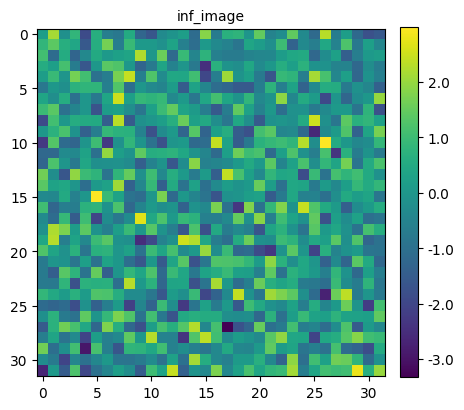

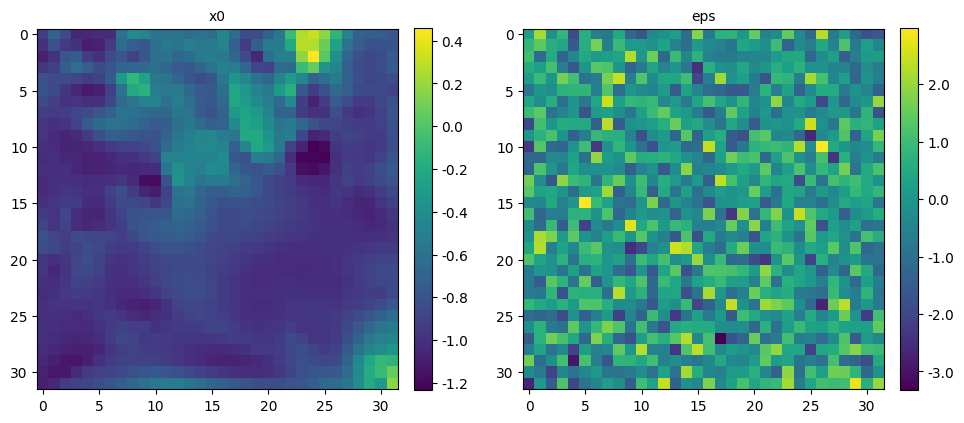

In [21]:
torch.manual_seed(42)
noise_to_add = torch.randn((1,1,32,32), device='cuda').float().to('cpu')
save_image(noise_to_add, names=['noise_to_add'], show=True)
ddim_sch.set_timesteps(1)
g = 12
# encoder_hidden_states = condition.flatten(2).permute(0, 2, 1)
fucs.check_nan_status(encoder_hidden_states)
encoder_hidden_states0 = torch.ones_like(encoder_hidden_states)
inf_image = noise_to_add
# torch.manual_seed(0)
# inf_image= torch.randn(1, 1, 32, 32)
# save_image(inf_image, names=['xt'], show=True)
for t in ddim_sch.timesteps:
    # print(t)
    eps = model(inf_image, t, encoder_hidden_states).sample
    # eps1 = model(inf_image, t, encoder_hidden_states0).sample
    # total_eps = eps1 + g * (eps - eps1)
    inf_image = ddim_sch.step(eps, torch.tensor([t]), inf_image, eta=0.0)[0]
    save_image(inf_image, names=['inf_image'], show=True)

    # refined_eps = model(inf_image, t, encoder_hidden_states).sample
    # # eps1 = model(inf_image, t, encoder_hidden_states0).sample
    # # total_eps = eps1 + g * (eps - eps1)
    # inf_image = ddim_sch.step(0.5*(eps + refined_eps), torch.tensor([t]), inf_image, eta=0.0)[0]

save_image(x0, inf_image, names=['x0', 'eps'], show=True)

In [9]:
ac = cal_acc(x0[0], inf_image[0])
print(ac)

tensor([-0.0815], grad_fn=<DivBackward0>)


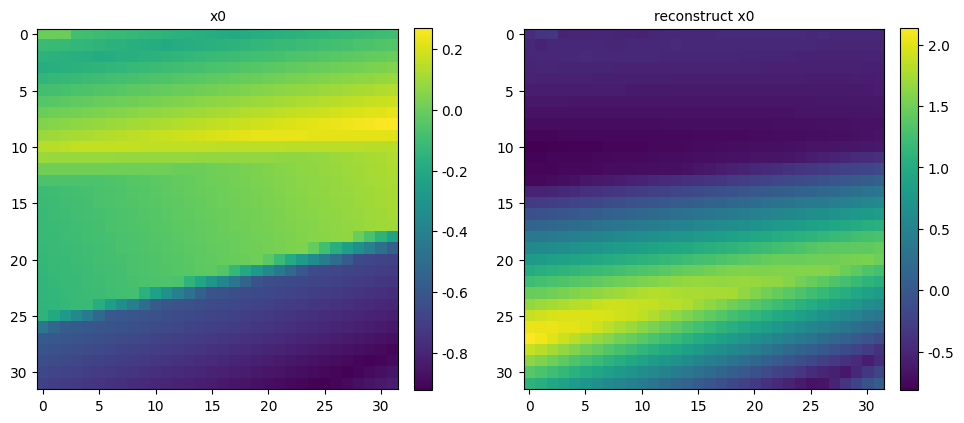

In [26]:
save_image(x0, inf_image, names=['x0', 'reconstruct x0'], show=True)